In [1]:
import pandas as pd
import numpy as np
from numpy import array
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras import regularizers
from matplotlib import pyplot
import openpyxl
import os
import tensorflow as tf
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [2]:
X=pd.read_excel(open('t.xlsx', 'rb'),sheet_name='最终数据集',usecols=[1,2,3,4,5])
y=pd.read_excel(open('t.xlsx', 'rb'),sheet_name='最终数据集', usecols=[6])

In [3]:
X
mm = MinMaxScaler()
X = mm.fit_transform(X)
X

array([[4.51309060e-03, 6.92956613e-01, 9.00893032e-01, 2.99035605e-01,
        0.00000000e+00],
       [1.72762148e-03, 7.61284971e-01, 8.18152035e-01, 2.87403338e-01,
        0.00000000e+00],
       [9.69722793e-03, 7.42928911e-01, 8.25046358e-01, 2.31613408e-01,
        0.00000000e+00],
       ...,
       [9.49731426e-06, 7.01200396e-01, 7.15529465e-01, 7.88507970e-02,
        0.00000000e+00],
       [9.59948855e-06, 5.62205664e-01, 7.61000940e-01, 1.08321132e-01,
        0.00000000e+00],
       [5.49939083e-05, 8.65418149e-01, 7.96174257e-01, 9.36803535e-02,
        0.00000000e+00]])

In [4]:
y = mm.fit_transform(y)
y

array([[0.1242358 ],
       [0.03740689],
       [0.40791365],
       ...,
       [0.02822565],
       [0.01971066],
       [0.3388823 ]])

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=1)

In [6]:
from keras.optimizers import adam_v2
model=Sequential() #初始化模型
model.add(Dense(32,input_shape=(5,),activation='tanh'))#添加一个隐含层，注：只是第一个隐含层需指定input_dim
model.add(Dense(16,activation='tanh'))
model.add(Dense(8,activation='tanh'))
model.add(Dense(4,activation='tanh'))
model.add(Dense(1)) #添加输出层
model.compile(loss='mse',optimizer='adam')  # 编译，指定目标函数与优化方法

In [7]:
# 定义查询函数
def query_instances(model, X_pool, n_instances=100):
    # 使用模型预测未标记的实例的输出值
    y_pred = model.predict(X_pool)
    
    # 计算每个实例的不确定度
    uncertainty = np.abs(y_pred - np.mean(y_train))
    
    # 选择不确定度最高的实例
    idx = np.argsort(uncertainty.flatten())[-n_instances:]
    return X_pool[idx], idx

In [8]:
X_pool=X_train.copy() 
y_pool=y_train.copy()# 初始化已标记的实例列表
X_labeled=[] 
y_labeled=[]
# 选择初始的标记实例
n_initial = 100
idx=np.random.choice(range(len(X_pool)), n_initial, replace=False)
X_labeled.extend(X_pool[idx])
y_labeled.extend(y_pool[idx])
X_pool = np.delete(X_pool, idx, axis=0)
y_pool = np.delete(y_pool, idx, axis=0)
# 开始主动学习的迭代过程
n_iterations = 25
n_per_iteration = 50
for i in range(n_iterations):
    print("Iteration:", i+1)
# 训练模型
history=model.fit(np.array(X_labeled), np.array(y_labeled),validation_data=(X_test,y_test), epochs=100, batch_size=100,verbose=2)

# 查询新的实例
X_new, idx = query_instances(model, X_pool, n_per_iteration)

# 将新的实例加入已标记的列表
X_labeled.extend(X_new)
y_labeled.extend(y_pool[idx])

# 从池中删除已选择的实例
X_pool = np.delete(X_pool, idx, axis=0)
y_pool = np.delete(y_pool, idx, axis=0)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Epoch 1/100
1/1 - 1s - loss: 0.2388 - val_loss: 0.2081 - 518ms/epoch - 518ms/step
Epoch 2/100
1/1 - 0s - loss: 0.1952 - val_loss: 0.1687 - 31ms/epoch - 31ms/step
Epoch 3/100
1/1 - 0s - loss: 0.1563 - val_loss: 0.1342 - 28ms/epoch - 28ms/step
Epoch 4/100
1/1 - 0s - loss: 0.1224 - val_loss: 0.1047 - 24ms/epoch - 24ms/step
Epoch 5/100
1/1 - 0s - loss: 0.0936 - val_loss: 0.0804 - 24ms/epoch - 24ms/step
Epoch 6/100
1/1 - 0s - loss: 0.0699 - val_loss: 0.0611 - 27ms/epoch - 27ms/step
Epoch 7/100
1/1 - 0s - loss: 0.0513 - val_loss: 0.0465 - 24ms/epoch - 24ms/step
Epoch 8/100
1/1 - 0s - loss: 0.0374 - val_loss: 0.0362 - 28ms/epoch - 28ms/step
Epoch 9/100
1/1 -

In [9]:
loss=history.history['loss']
val_loss=history.history['val_loss']

In [10]:
np.savetxt('act_loss.txt',loss,fmt='%f')
np.savetxt('act_val_loss.txt',val_loss,fmt='%f')

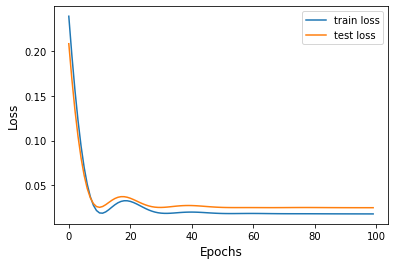

In [11]:
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='test loss')
pyplot.legend()
pyplot.xlabel('Epochs', fontsize = 12)
pyplot.ylabel('Loss', fontsize = 12)
pyplot.savefig("./loss.png")

In [12]:
prediction_y = model.predict(X_test)

In [13]:
Y_pre=mm.inverse_transform(prediction_y)

In [14]:
Y_real=mm.inverse_transform(y_test)

In [15]:
cha=Y_pre-Y_real

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(Y_real, Y_pre)
mse = mean_squared_error(Y_real, Y_pre)
print('Test MAE: %.3f' % mae)
print('Test MSE: %.3f' % mse)

Test MAE: 1.042
Test MSE: 2.046


In [17]:
from math import sqrt
rmse = sqrt(mean_squared_error(Y_real, Y_pre))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.430


In [18]:
def MAPE(Y_real,Y_pre):#计算mape
    return np.mean(np.abs((Y_real - Y_pre) / Y_real)) * 100

In [19]:
mape=MAPE(Y_real, Y_pre)

In [20]:
mape

364.3489990645345